In [1]:
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
import pandas as pd
import os
import seaborn as sns
import random 
import scipy as sc
import statsmodels.api as sm
import scipy.stats as stats
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cartopy as cp
import stormeunice as eun
import multiprocessing
import glob
import dask
import metpy
from metpy.units import units

sns.set_theme(style="white")
sns.set_style("white")
%matplotlib inline


# Import data

In [2]:
P1 = multiprocessing.Pool(40)

ifs_tracks = P1.map(eun.lagrangian.Lagrange.import_medr_tracks_TE, 
                    glob.glob('/home/l/leach/Attribution/NA-Storms/Nick/Scripts/tracking/TE/TEStitch_[!2]*'))

P1.close()

ifs_tracks = pd.concat(ifs_tracks)
ifs_tracks['date'] = pd.to_datetime(ifs_tracks.loc[:,['year','month','day','hour']])

## add era track in
era_track = pd.read_csv('/home/l/leach/Attribution/NA-Storms/Nick/Scripts/tracking/TE/TEStitch_2022_0',
                        skipinitialspace=True)

era_track['expid'] = 'era5'
era_track['experiment'] = 'era5'
era_track['inidate'] = pd.to_datetime('2022-01-01')
era_track['number'] = 0
era_track['date'] = pd.to_datetime(era_track.loc[:,['year','month','day','hour']])

all_tracks = pd.concat([ifs_tracks,era_track])

eunice_track = era_track.query('track_id==5')

In [3]:
ifs_tracks_filter = ifs_tracks.groupby(['track_id','inidate','experiment','number']).agg(dict(date=min, day=np.size, lon=lambda x: x.iloc[0], lat=lambda x: x.iloc[0], msl=min))
eunice_filter = eunice_track.groupby(['track_id','inidate','experiment','number']).agg(dict(date=min, day=np.size, lon=lambda x: x.iloc[0], lat=lambda x: x.iloc[0], msl=min)).iloc[0]

# starttime criterion - must be detected within 12 hours (before or after) the ERA5 track detectino time
starttime_crit = (ifs_tracks_filter.date - eunice_filter.date).dt.total_seconds().abs()<(12*60*60)
# starting location criterion - must start within 10 degrees of the ERA5 track starting point
startloc_crit = np.sqrt((ifs_tracks_filter.lon-eunice_filter.lon)**2+(ifs_tracks_filter.lat-eunice_filter.lat)**2)<10
# depth criterion - must reach a depth of at least 980 hPa
minmsl_crit = ifs_tracks_filter.msl < 98000

ifs_tracks_filtered = ifs_tracks_filter.loc[starttime_crit&startloc_crit&minmsl_crit]
ifs_eunice_list = ifs_tracks.set_index(['track_id','inidate','experiment','number']).sort_index().loc[ifs_tracks_filtered.index].reset_index()

In [4]:
multi_track_members = ifs_eunice_list.groupby(['inidate','experiment','number','track_id']).agg(dict(year = lambda x: 1)).groupby(['inidate','experiment','number']).count().query('year > 1')

for idx in multi_track_members.index:
    track_dists = ifs_eunice_list.query('inidate=="{}" & experiment=="{}" & number=={}'.format(*idx)).groupby('track_id').apply(lambda x: eun.lagrangian.Lagrange.eunice_dist(x,eunice_track=eunice_track))
    num_reject = track_dists.idxmax()
    ifs_eunice_list_idx = ifs_eunice_list.query('inidate=="{}" & experiment=="{}" & number=={} & track_id=={}'.format(*idx,num_reject)).index
    ifs_eunice_list = ifs_eunice_list.drop(ifs_eunice_list_idx)

In [5]:
ERA5_tracks = pd.read_hdf('/gf3/predict2/AWH012_LEACH_NASTORM/DATA/postproc/tracks/ERA5/EU025/sfc/2022.h5')
ERA5_eunice_track = ERA5_tracks.query('uid=="202202079"')

ERA5_data = xr.open_dataset('/gf3/predict2/AWH012_LEACH_NASTORM/DATA/ERA5/EU025/sfc/2022.nc').sel(time=ERA5_eunice_track.date.values)
ERA5_data['centroid_lon'] = ('time',(ERA5_eunice_track.long*4).round()/4)
ERA5_data['centroid_lat'] = ('time',(ERA5_eunice_track.lat*4).round()/4)

ERA5_eunice_stormframe = ERA5_data.groupby('time').apply(eun.lagrangian.Lagrange.lagrangian_frame)

In [6]:
%%capture 
# Ignore outputs

curr_storms = xr.open_mfdataset('/gf3/predict2/AWH012_LEACH_NASTORM/DATA/MED-R/ENS/EU025/pl/pf/extravars/*.nc',
                                preprocess=lambda x: eun.lagrangian.Lagrange.preproc_to_stormframe_max_deepening(x, ifs_eunice_list=ifs_eunice_list, sfc=False),
                                combine='nested',
                                concat_dim=['inidate'],
                                parallel=True, 
                                engine='netcdf4')
pi_storms = xr.open_mfdataset('/gf3/predict2/AWH012_LEACH_NASTORM/DATA/MED-R/EXP/pi/EU025/pl/pf/extravars/*.nc',
                              preprocess=lambda x: eun.lagrangian.Lagrange.preproc_to_stormframe_max_deepening(x, ifs_eunice_list=ifs_eunice_list, sfc=False),
                              combine='nested',
                              concat_dim=['inidate'],
                              parallel=True, 
                              engine='netcdf4')
incr_storms = xr.open_mfdataset('/gf3/predict2/AWH012_LEACH_NASTORM/DATA/MED-R/EXP/incr/EU025/pl/pf/extravars/*.nc',
                                preprocess=lambda x: eun.lagrangian.Lagrange.preproc_to_stormframe_max_deepening(x, ifs_eunice_list=ifs_eunice_list,sfc=False),
                                combine='nested',
                                concat_dim=['inidate'],
                                parallel=True, 
                                engine='netcdf4')

# Initial tests

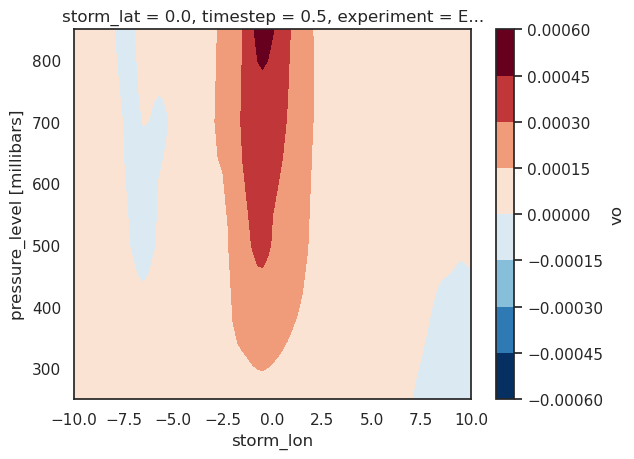

In [7]:
curr_storms.sel(storm_lat = 0, inidate = '2022-02-14', timestep = 0.5).squeeze().mean(dim = 'number').vo.plot.contourf(levels = 10)

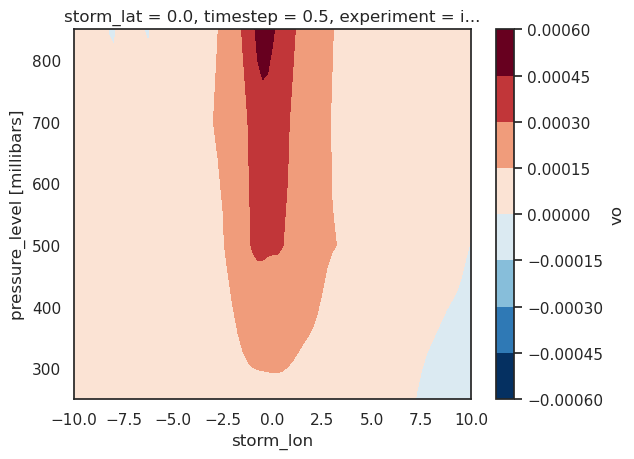

In [25]:
incr_storms.sel(storm_lat = 0, inidate = '2022-02-14', timestep = 0.5).squeeze().mean(dim = 'number').vo.plot.contourf(levels = 10)

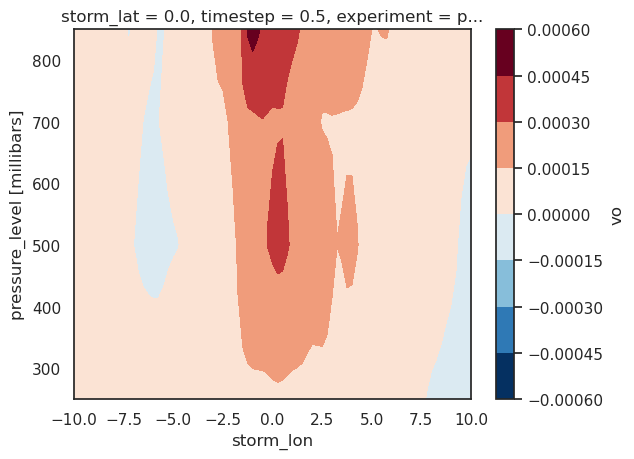

In [26]:
pi_storms.sel(storm_lat = 0, inidate = '2022-02-14', timestep = 0.5).squeeze().mean(dim = 'number').vo.plot.contourf(levels = 10)

# Comparison plot for W-E cross-sections

In [8]:
# calculate eq potential temperature
experiments = ['pi', 'curr', 'incr']
eq_pot_temp = {}
storms = {'pi' : pi_storms, 'curr' : curr_storms, 'incr' : incr_storms}

for exp in experiments:
    pot_temperature = metpy.calc.potential_temperature(850 * units.hPa, storms[exp].t * units.kelvin)
    dewpoint = metpy.calc.dewpoint_from_relative_humidity(storms[exp].t * units.kelvin, storms[exp].r * units.percent)

    eq_pot_temp[exp] = metpy.calc.equivalent_potential_temperature(850 * units.hPa, storms[exp].t * units.kelvin, dewpoint)

/tmp/user/27529/ipykernel_421560/926484715.py:8: UserWarning: Relative humidity >120%, ensure proper units.
  dewpoint = metpy.calc.dewpoint_from_relative_humidity(storms[exp].t * units.kelvin, storms[exp].r * units.percent)
/tmp/user/27529/ipykernel_421560/926484715.py:8: UserWarning: Relative humidity >120%, ensure proper units.
  dewpoint = metpy.calc.dewpoint_from_relative_humidity(storms[exp].t * units.kelvin, storms[exp].r * units.percent)
/tmp/user/27529/ipykernel_421560/926484715.py:8: UserWarning: Relative humidity >120%, ensure proper units.
  dewpoint = metpy.calc.dewpoint_from_relative_humidity(storms[exp].t * units.kelvin, storms[exp].r * units.percent)


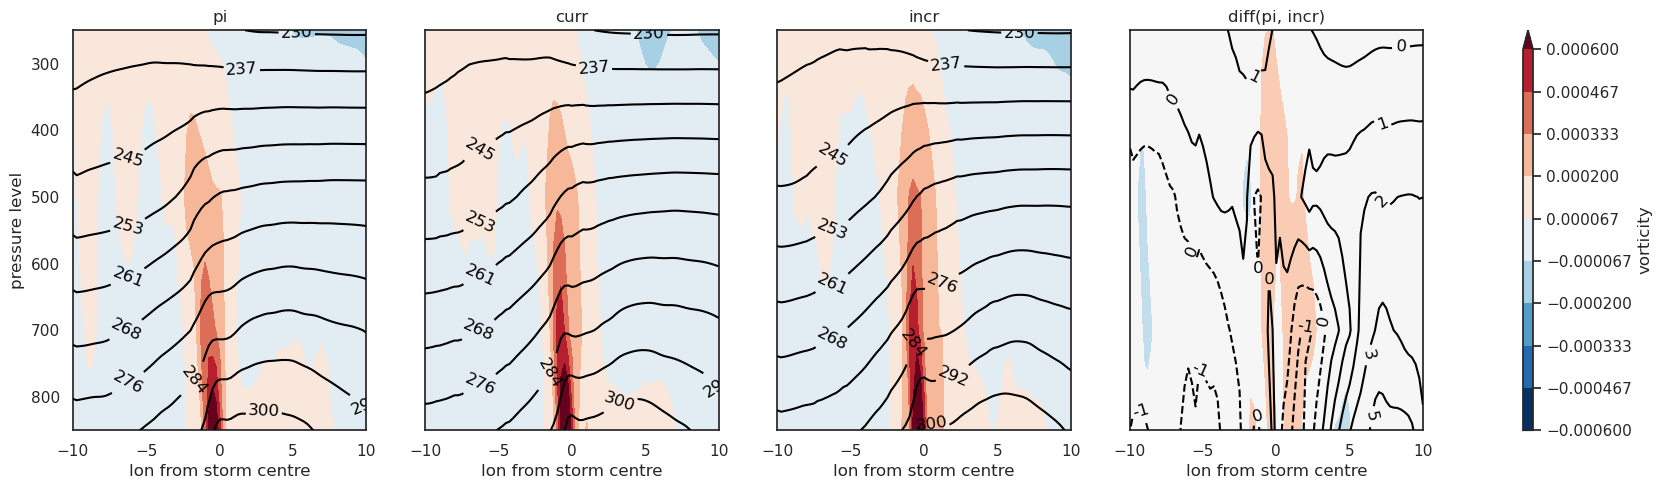

In [9]:
fig, axes = plt.subplots(1, 4, figsize=(20, 5), sharey=True)
vmin = -0.0006
vmax = 0.0006
levs = 10
ts = 0
ini = '2022-02-14'
t_min = 230
t_max = 300
num_levels_t = 10

# pi
pi = pi_storms.sel(storm_lat = 0, inidate = ini, timestep = ts).squeeze().mean(dim = 'number')
c = pi.vo.plot.contourf(levels = levs, cmap="RdBu_r", ax=axes[0], add_colorbar=False, vmin = vmin, vmax = vmax)
axes[0].set_ylabel('pressure level')
axes[0].set_xlabel('lon from storm centre')
axes[0].set_title('pi')

clevs_p = np.linspace(t_min, t_max, num_levels_t) 
cs = axes[0].contour(pi.storm_lon.values, pi.level.values,
                     eq_pot_temp['pi'].sel(inidate=ini, storm_lat=0, timestep=ts).mean(dim='number').squeeze(),
                     clevs_p, colors='black',
                    #  transform=projection,
                     zorder = 16)
plt.clabel(cs, fmt='%d')
axes[0].invert_yaxis()

# curr
curr = curr_storms.sel(storm_lat = 0, inidate = ini, timestep = ts).squeeze().mean(dim = 'number')
curr.vo.plot.contourf(ax=axes[1],levels=levs, cmap="RdBu_r", vmin = vmin, vmax = vmax, add_colorbar=False)
axes[1].set_ylabel('')
axes[1].set_xlabel('lon from storm centre')
axes[1].set_title('curr')

clevs_p = np.linspace(t_min, t_max, num_levels_t) 
cs = axes[1].contour(pi.storm_lon.values, pi.level.values,
                     eq_pot_temp['curr'].sel(inidate=ini, storm_lat=0, timestep=ts).mean(dim='number').squeeze(),
                     clevs_p, colors='black',
                    #  transform=projection,
                     zorder = 16)
plt.clabel(cs, fmt='%d')
axes[1].invert_yaxis()

# incr
incr = incr_storms.sel(storm_lat = 0, inidate = ini, timestep = ts).squeeze().mean(dim = 'number')
incr.vo.plot.contourf(ax=axes[2], levels=levs, cmap="RdBu_r", vmin = vmin, vmax = vmax, add_colorbar=False)
axes[2].set_ylabel('')
axes[2].set_xlabel('lon from storm centre')
axes[2].set_title('incr')

clevs_p = np.linspace(t_min, t_max, num_levels_t) 
cs = axes[2].contour(pi.storm_lon.values, pi.level.values,
                     eq_pot_temp['incr'].sel(inidate=ini, storm_lat=0, timestep=ts).mean(dim='number').squeeze(),
                     clevs_p, colors='black',
                    #  transform=projection,
                     zorder = 16)
plt.clabel(cs, fmt='%d')
axes[2].invert_yaxis()

# diff
diff = incr - pi
diff.vo.plot.contourf(ax=axes[3], levels=levs, cmap="RdBu_r", vmin = vmin, vmax = vmax, add_colorbar=False)
axes[3].set_xlabel('lon from storm centre')
axes[3].set_ylabel('')
axes[3].set_title('diff(pi, incr)')

clevs_p = np.linspace(-5, 5, num_levels_t) 
cs = axes[3].contour(pi.storm_lon.values, pi.level.values,
                     eq_pot_temp['incr'].sel(inidate=ini, storm_lat=0, timestep=ts).mean(dim='number').squeeze() - eq_pot_temp['pi'].sel(inidate=ini, storm_lat=0, timestep=ts).mean(dim='number').squeeze(),
                     clevs_p, colors='black',
                    #  transform=projection,
                     zorder = 16)
plt.clabel(cs, fmt='%d')
axes[3].invert_yaxis()

plt.subplots_adjust(bottom=0.1, right=0.8, top=0.9)
cax = plt.axes([0.85, 0.1, 0.005, 0.8])
cbar = plt.colorbar(c, cax=cax, label = 'vorticity')
# cbar.minorticks_on()

# Comparison plot for S-N cross-sections

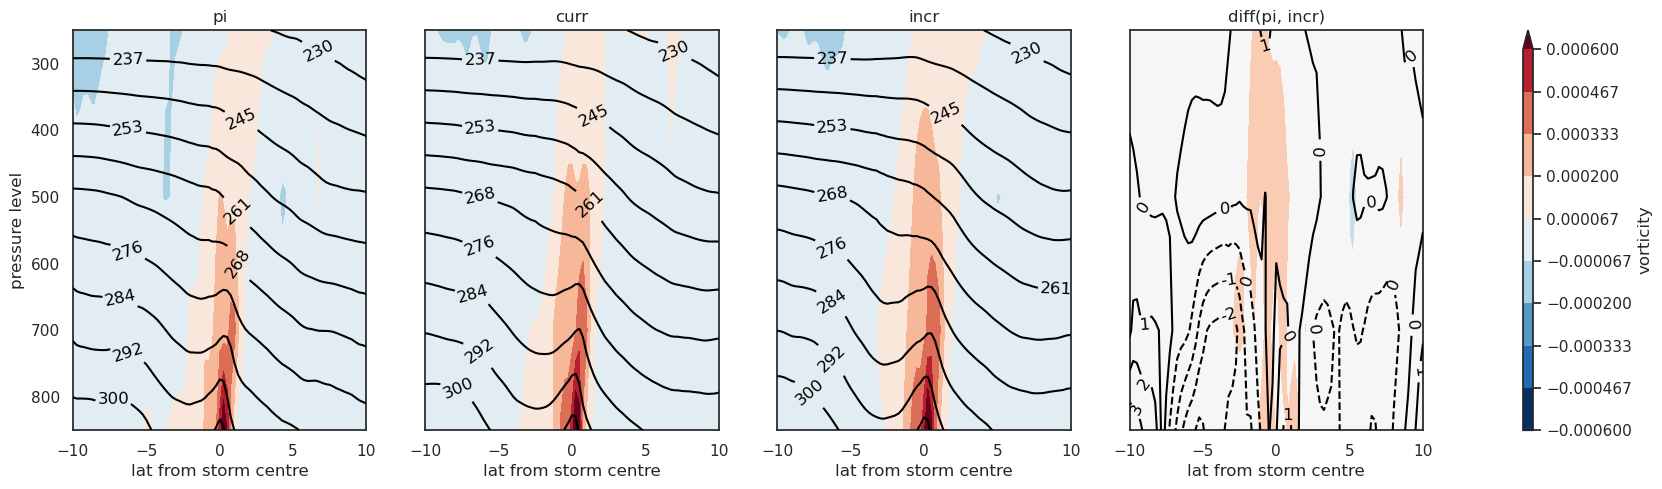

In [10]:
fig, axes = plt.subplots(1, 4, figsize=(20, 5), sharey=True)
vmin = -0.0006
vmax = 0.0006
levs = 10
ts = 0
ini = '2022-02-14'
t_min = 230
t_max = 300
num_levels_t = 10

# pi
pi = pi_storms.sel(storm_lon = 0, inidate = ini, timestep = ts).squeeze().mean(dim = 'number')
c = pi.vo.plot.contourf(levels = levs, cmap="RdBu_r", ax=axes[0], add_colorbar=False, vmin = vmin, vmax = vmax)
axes[0].set_ylabel('pressure level')
axes[0].set_xlabel('lat from storm centre')
axes[0].set_title('pi')

clevs_p = np.linspace(t_min, t_max, num_levels_t) 
cs = axes[0].contour(pi.storm_lat.values, pi.level.values,
                     eq_pot_temp['pi'].sel(inidate=ini, storm_lon=0, timestep=ts).mean(dim='number').squeeze(),
                     clevs_p, colors='black',
                    #  transform=projection,
                     zorder = 16)
plt.clabel(cs, fmt='%d')
axes[0].invert_yaxis()

# curr
curr = curr_storms.sel(storm_lon = 0, inidate = ini, timestep = ts).squeeze().mean(dim = 'number')
curr.vo.plot.contourf(ax=axes[1],levels=levs, cmap="RdBu_r", vmin = vmin, vmax = vmax, add_colorbar=False)
axes[1].set_ylabel('')
axes[1].set_xlabel('lat from storm centre')
axes[1].set_title('curr')

clevs_p = np.linspace(t_min, t_max, num_levels_t) 
cs = axes[1].contour(pi.storm_lat.values, pi.level.values,
                     eq_pot_temp['curr'].sel(inidate=ini, storm_lon=0, timestep=ts).mean(dim='number').squeeze(),
                     clevs_p, colors='black',
                    #  transform=projection,
                     zorder = 16)
plt.clabel(cs, fmt='%d')
axes[1].invert_yaxis()

# incr
incr = incr_storms.sel(storm_lon = 0, inidate = ini, timestep = ts).squeeze().mean(dim = 'number')
incr.vo.plot.contourf(ax=axes[2], levels=levs, cmap="RdBu_r", vmin = vmin, vmax = vmax, add_colorbar=False)
axes[2].set_ylabel('')
axes[2].set_xlabel('lat from storm centre')
axes[2].set_title('incr')

clevs_p = np.linspace(t_min, t_max, num_levels_t) 
cs = axes[2].contour(pi.storm_lat.values, pi.level.values,
                     eq_pot_temp['incr'].sel(inidate=ini, storm_lon=0, timestep=ts).mean(dim='number').squeeze(),
                     clevs_p, colors='black',
                    #  transform=projection,
                     zorder = 16)
plt.clabel(cs, fmt='%d')
axes[2].invert_yaxis()

# diff
diff = incr - pi
diff.vo.plot.contourf(ax=axes[3], levels=levs, cmap="RdBu_r", vmin = vmin, vmax = vmax, add_colorbar=False)
axes[3].set_xlabel('lat from storm centre')
axes[3].set_ylabel('')
axes[3].set_title('diff(pi, incr)')

clevs_p = np.linspace(-5, 5, num_levels_t) 
cs = axes[3].contour(pi.storm_lat.values, pi.level.values,
                     eq_pot_temp['incr'].sel(inidate=ini, storm_lon=0, timestep=ts).mean(dim='number').squeeze() - eq_pot_temp['pi'].sel(inidate=ini, storm_lon=0, timestep=ts).mean(dim='number').squeeze(),
                     clevs_p, colors='black',
                    #  transform=projection,
                     zorder = 16)
plt.clabel(cs, fmt='%d')
axes[3].invert_yaxis()

plt.subplots_adjust(bottom=0.1, right=0.8, top=0.9)
cax = plt.axes([0.85, 0.1, 0.005, 0.8])
cbar = plt.colorbar(c, cax=cax, label = 'vorticity')